In [1]:
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from collections import Counter


In [2]:
folder = './data/'
files = [f for f in listdir(folder) if isfile(join(folder, f))]
print('Amount of the files:', len(files))

# sample屬於哪種 malware family
malware_family = pd.read_csv("./dataset.csv")
malware_family

Amount of the files: 1290


C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,filename,label,threshold(report >= 5),CPU Architecture
0,6727b9dcc9db82a3de5096edfdc873aa0f6e8e3c28704d...,Mirai,True,unknown
1,67a4ecd639251923637abf87927a2d000e5ed795c45bba...,Bashlite,True,armel
2,67978fe14bbaa973412f5fd2d80bf8cf5205607004e0c4...,Mirai,True,armel
3,67c690b32b2d8667f0931952dcafb36c498f167cf355ff...,Unknown,False,x86el
4,6737cb775774a9c0f3991a0b563c86f73402c9ae46751c...,Mirai,True,ppceb
...,...,...,...,...
279882,1e21f6257122dbb017de24aa2329c94157833dd17455a7...,BenignWare,None,mipseb
279883,1e36b2e47f6a8c41d4849404d72d4bd808c62bcc8df0a3...,BenignWare,None,armel
279884,1e33231803460d942dbbf0477da5db71f211b0e887e55c...,BenignWare,None,mips64eb
279885,1ed5d0037e5b51e4040fa1ecdf5983138a041470c8d04c...,BenignWare,None,mipseb


In [3]:
counter = Counter(malware_family['label'])
counter

Counter({'Mirai': 72644,
         'Bashlite': 48094,
         'Unknown': 15223,
         'Android': 6712,
         'Tsunami': 2796,
         'Hajime': 635,
         'Dofloo': 2044,
         'Xorddos': 633,
         'Pnscan': 24,
         'BenignWare': 131082})

In [45]:
mal_type = 'Mirai'
mal_list = malware_family[malware_family['label'] == mal_type]['filename'].tolist()

benign_type = 'Bashlite' # pretend this as benign-ware
benign_list = malware_family[malware_family['label'] == benign_type]['filename'].tolist()

In [46]:
X_mal = [] # M
X_benign = [] # B
l = 300
for file in files:
    if file[:-4] in mal_list:
        data = pd.read_csv(folder + file)['SYSCALL']
        seq= data.tolist()[:l]
        if len(seq) >= l:
            X_mal.append(seq)
            
    elif file[:-4] in benign_list:
        data = pd.read_csv(folder + file)['SYSCALL']
        seq= data.tolist()[:l]
        if len(seq) >= l:
            X_benign.append(seq)

C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (3,6,8,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6,8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
C:\Users\cherry\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (6,7,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell

In [47]:
print(len(X_mal))
print(len(X_benign))

420
300


In [48]:
X_mal = np.array(X_mal)
X_benign = np.array(X_benign)

X = np.concatenate([X_benign, X_mal])
Y = np.zeros(len(X))
Y[len(X_benign):] = 1

In [49]:
unique, counts = np.unique(X, return_counts=True)
#dict(zip(unique, counts))

A = unique.tolist() # the set of all API calls

In [8]:
def x_in_y(query, base):
    l = len(query)
    for i in range(len(base)):
        if base[i:i+l] == query:
            return True
    return False

def F(d, ng):
    # 分母: len(d)
    count = 0
    for seq in d:
        if x_in_y(ng, seq):
            count += 1
    return count / float(len(d))


def encode(A, s):
    result = []
    for i in range(len(s)):
        for j in range(len(A)):
            if s[i] == A[j]:
                result.append(j)
                break
    return result

In [50]:
M = [] # encode both malware and benign-ware sample to int sequence
B = []

for i in range(len(X_mal)):
    M.append(encode(A, X_mal[i]))

for i in range(len(X_benign)):
    B.append(encode(A, X_benign[i]))

In [10]:
F(B, [19])

0.006666666666666667

In [52]:
# train a random forest malware detector
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=66)
rf.fit(np.array(B + M), Y)

from sklearn.metrics import accuracy_score

print('train acc:', accuracy_score(Y, rf.predict(np.array(B + M))))

train acc: 1.0


In [36]:
# np.save('X', np.array(B + M))
# np.save('Y', Y)

In [42]:
import matplotlib.pyplot as plt

def feature_level_attack(model, x, A, total_round = 10):
    # model: trained model detector
    # x: input api sequence with length l
    # A: set of api call
    r = 1 # round 
    x_star = x
    
    class_0_prob = []
    class_1_prob = []
    
    while(model.predict(x_star) == 1):
        print('round ', r)
        r += 1
        
        i = np.random.randint(0, l-1)
        max_F = 0
        max_idx = 0
        for idx in range(len(A)):
            f = F(B, [x_star[0, i]] + [idx]) - F(M, [x_star[0, i]] + [idx])
            
            if f > max_F:
                print(f, max_F)
                max_F = f
                max_idx = idx
                
        
        #x_star = x_star[0, :idx] + [max_idx] + x_star[0, idx:]
        x_star = np.concatenate((x_star[0, 1:i], [max_idx], x_star[0, i:])).reshape(1, -1)
        print([x_star])
        prob = model.predict_proba(x_star)
        print(prob)
        class_0_prob.append(prob[0, 0])
        class_1_prob.append(prob[0, 1])
        
        if r == (total_round + 1):
            break
    plt.plot(np.arange(len(class_0_prob)) + 1, class_0_prob)
    plt.plot(np.arange(len(class_1_prob)) + 1, class_1_prob)
    return x_star

round  1
0.03666666666666667 0
0.13333333333333333 0.03666666666666667
0.1357142857142857 0.13333333333333333
0.4038095238095238 0.1357142857142857
[array([[ 67,  66,  66,  85,  18,  39,  17,  11,  11, 150,  36,  37, 151,
        159, 159, 150,  26,  26,  26,  21,   0,  79,  17,  17,  17, 150,
         26,  26,  26,  85,  23,  23,  54,  85,  18,  39,  17, 150,  36,
         37, 151, 150,  11,  85,  23,  23,  80,  71,  54,  71,  21,  71,
          0,  71,  54,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71, 

0.5995238095238095 0.00857142857142857
[array([[ 39,  17,  11,  11, 150,  36,  37, 151, 159, 159, 150,  26,  26,
         26,  21,   0,  79,  17,  17,  17, 150,  26,  26,  26,  85,  23,
         23,  54,  85,  18,  39,  17, 150,  36,  37, 151, 150,  11,  85,
         18,  23,  23,  80,  71,  54,  71,  21,  71,   0,  71,  54,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71

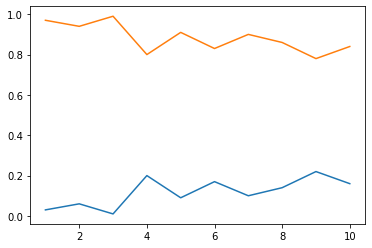

In [53]:
# generate AE sample from the given malware call sequence
x = feature_level_attack(rf, np.array(M[0]).reshape(1, -1), A)

In [ ]:
x = feature_level_attack(rf, np.array(M[0]).reshape(1, -1), A, 50)

round  1
0.0033333333333333335 0
0.006666666666666667 0.0033333333333333335
[array([[ 67,  66,  66,  85,  18,  39,  17,  11,  11, 150,  36,  37, 151,
        159, 159, 150,  26,  26,  26,  21,   0,  79,  17,  17,  17, 150,
         26,  26,  26,  85,  23,  23,  54,  85,  18,  39,  17, 150,  36,
         37, 151, 150,  11,  85,  23,  23,  80,  71,  54,  71,  21,  71,
          0,  71,  54,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         69,  71,  71,  71,  71,  71,  71,  71,

0.007142857142857142 0
0.01142857142857143 0.007142857142857142
[array([[ 39,  17,  11,  11, 150, 150,  36,  37, 151, 159, 159, 150,  26,
         26,  26,  21,   0,  79,  17,  17,  17, 150,  26,  26,  26,  85,
         23,  23,  54,  85,  18,  39,  17, 150,  36,  37, 151, 150,  11,
         21,  85,  23,  23,  80,  71,  54,  71,  21,  71, 157,   0,  71,
         54,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  69,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,
         69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  

[array([[150,  36,  37, 151, 159, 159, 150, 159,  26,  26,  26,  21,   0,
         13,  79,  17,  17,  17, 150, 159,  26,  26,  26,  85,  23,  23,
         54,  85,  18,  39,  17, 150,  36,  37, 151, 150,  11,  21,  85,
         23,  23,  80,  71,  54,  71,  21,  71, 157,   0,  71,  54,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  69,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  7

0.02 0
0.05 0.02
[array([[159, 150, 159,  26,  26,  26,  21,   0,  13,  79,  45,  17,  17,
         17, 150, 159,  26,  26,  26,  85,  23,  23,  54,  85,  18,  39,
         17, 150,  36,  37, 151, 150,  11,  21,  85,  23,  23,  80,  71,
         54,  71,  21,  71, 157,   0,  71,  54,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  67,  69,  71,  71,  71,  71,  69,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71, 

0.13333333333333333 0.03666666666666667
0.1357142857142857 0.13333333333333333
0.4038095238095238 0.1357142857142857
[array([[ 26,  21,   0,  13,  79,  45,  17,  17,  17, 150, 159,  26,  26,
         26,  85,  23,  23,  54,  85,  18,  39,  17, 150,  36,  37, 151,
        150,  11,  21,  85,  23,  23,  80,  71,  54,  71,  21,  71, 157,
          0,  71,  54,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         67,  69,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,
      

0.02 0
0.05 0.02
[array([[ 45,  17,  17,  17, 150, 159,  26,  26,  26,  85,  23,  23,  54,
         85,  18,  39,  17, 150,  36,  37, 151, 150,  11,  21,  85,  23,
         23,  80,  71,  54,  71,  21,  71, 157,   0,  71,  54,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  67,  67,  69,  71,  71,
         71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  69,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71, 

0.3233333333333333 0
[array([[159,  26,  26,  26,  85,  23,  23,  54,  85,  18,  39,  17, 150,
         36,  37, 151, 150,  11,  21,  85,  23,  23,  80,  71,  54,  71,
         21,  71, 157,   0,  71,  54,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  69,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  67,  67,  69,  71,  71,  71,  71,  69,  69,
         71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  69,
         71,  71,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  69,  

0.0033333333333333335 0
0.006666666666666667 0.0033333333333333335
[array([[ 23,  23,  54,  85,  18,  39,  17, 150,  36,   0,  37, 151, 150,
         11,  21,  85,  23,  23,  80,  71,  54,  71,  21,  71, 157,   0,
         71,  54,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,  71,
         71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         69,  71,  71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  69,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,  71,
         71,  71,  67,  67,  69,  71,  71,  71,  71,  69,  69,  71,  71,
         69,  71,  71,  71,  71,  71,  71,  71,  71,  69,  71,  69,  71,
         71,  71,  71,  71,  69,  71,  71,  71,  71,  71

0.0033333333333333335 0
0.006666666666666667 0.0033333333333333335


## 下面不重要

In [31]:
np.arange(3)

array([0, 1, 2])

In [24]:
x = feature_level_attack(rf, np.array(M[0]).reshape(1, -1),A)

round  1


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [25]:
x_star = np.array(M[2]).reshape(1, -1)
x_star = np.concatenate((x_star[0, 1:2], [2], x_star[0, 2:])).reshape(1, -1)
rf.predict(x_star)

array([1.])

In [42]:
l = x_star[0, :45].tolist()
l.append(11)
l

[67,
 2,
 66,
 66,
 85,
 18,
 39,
 17,
 11,
 11,
 85,
 86,
 23,
 23,
 86,
 86,
 150,
 36,
 37,
 151,
 58,
 159,
 159,
 26,
 21,
 79,
 0,
 17,
 17,
 17,
 26,
 54,
 54,
 150,
 54,
 54,
 21,
 0,
 26,
 3,
 26,
 85,
 18,
 39,
 17,
 11]

In [60]:
np.arange(50) + 1

array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [56]:
for i in range(10):
    print(np.array(B[i]).reshape(1, -1)[0])
    print(rf.predict_proba(np.array(M[i]).reshape(1, -1)))

[20 144 144 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149 149
 149 149 149 149 149 149 149 149 149 149 149 149 149

In [32]:
rf.feature_importances_

array([0.00000000e+00, 4.08673605e-02, 4.06055054e-02, 7.15353591e-03,
       1.61924539e-02, 1.07362558e-02, 1.52540602e-02, 2.02295193e-02,
       8.38825196e-03, 6.54138327e-03, 6.68865924e-03, 1.12125186e-02,
       2.88660031e-02, 8.59691957e-03, 7.86481853e-03, 1.19015986e-02,
       4.51911286e-03, 4.55940687e-03, 1.48768020e-02, 4.21729988e-03,
       9.83889440e-03, 3.85082520e-03, 1.19808713e-03, 3.39679810e-03,
       1.57300404e-02, 1.53530834e-02, 1.14570543e-02, 4.53843680e-03,
       1.50898578e-02, 2.96039292e-02, 2.19963985e-02, 1.90114648e-02,
       2.38913311e-02, 2.13641174e-02, 2.12258002e-02, 1.01518422e-02,
       1.38663586e-02, 7.12720179e-03, 6.87824491e-03, 5.12846865e-03,
       6.64136264e-03, 1.22243499e-02, 1.40732599e-02, 8.51935190e-03,
       3.32629320e-03, 7.26757129e-03, 3.86937696e-03, 3.68131168e-03,
       3.04529099e-04, 1.34737581e-05, 1.88192010e-03, 2.48445278e-03,
       6.39112452e-05, 3.73572298e-04, 4.66970413e-04, 3.72184801e-04,
      

### 12/2 暫時結論

若如論文所說只取前 300 個 API sequence，並且用 iterative 的方法一次加一個進去，以 random forest 模型為例，對於兩個 class 的機率改變非常緩慢與低落，甚至會又往 malware 上升，因此懷疑此方法對該資料集的可行性。